In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

In [3]:
# ------------------------
# Step 1: Dataset & Dataloaders
# ------------------------
data_dir = "database"   # has dysgraphia/ and normal/
batch_size = 16
img_size = 224

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)

# Split train/val (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Classes: ['Dysgraphia', 'Normal']


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\Server\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Server\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss, correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / len(train_dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/5, Train Loss: 0.7632, Train Acc: 0.7487, Val Loss: 17.9186, Val Acc: 0.7000
Epoch 2/5, Train Loss: 0.3794, Train Acc: 0.8543, Val Loss: 0.4732, Val Acc: 0.8600
Epoch 3/5, Train Loss: 0.2601, Train Acc: 0.8844, Val Loss: 0.3975, Val Acc: 0.8600
Epoch 4/5, Train Loss: 0.1818, Train Acc: 0.9246, Val Loss: 0.2543, Val Acc: 0.9000
Epoch 5/5, Train Loss: 0.0850, Train Acc: 0.9648, Val Loss: 0.1179, Val Acc: 0.9200


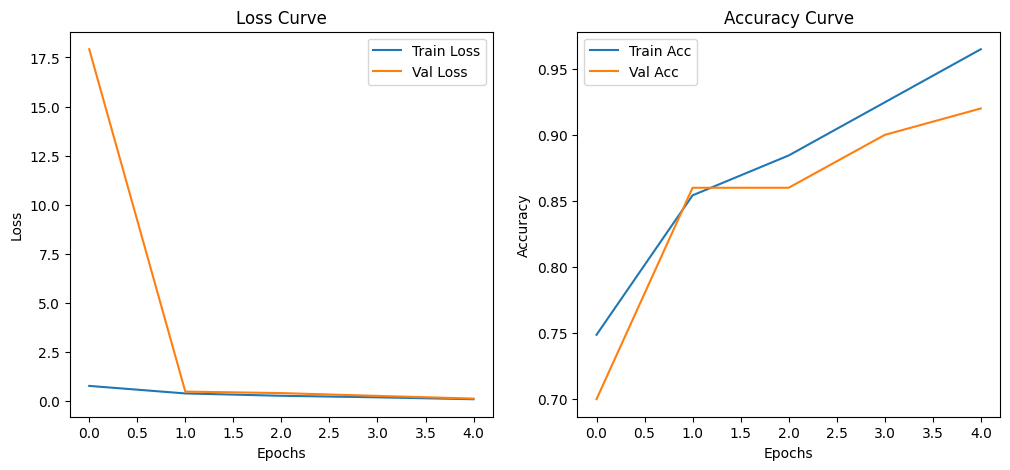

In [7]:
# ------------------------
# Step 4: Training Graphs
# ------------------------
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

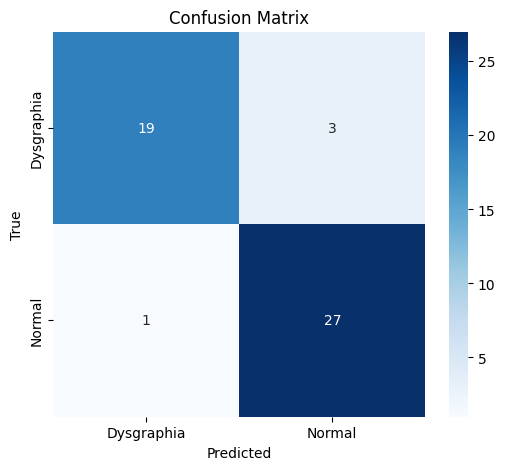

Classification Report:
              precision    recall  f1-score   support

  Dysgraphia       0.95      0.86      0.90        22
      Normal       0.90      0.96      0.93        28

    accuracy                           0.92        50
   macro avg       0.93      0.91      0.92        50
weighted avg       0.92      0.92      0.92        50



In [8]:
# ------------------------
# Step 5: Confusion Matrix & Report
# ------------------------
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

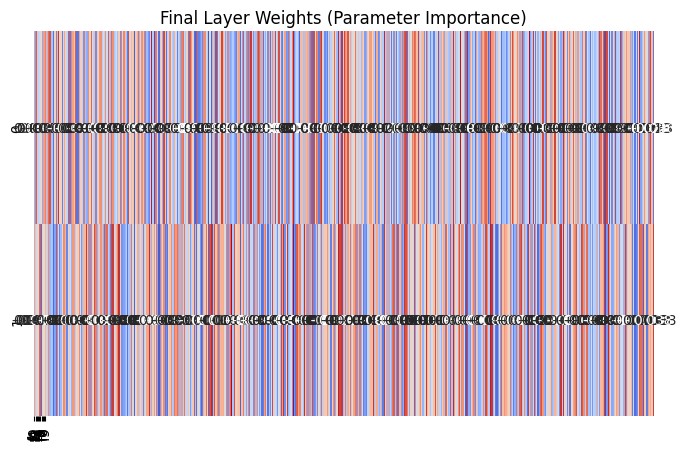

In [9]:
# ------------------------
# Step 6: Parameter Importance (basic weight visualization)
# ------------------------
# Example: inspect final FC layer weights
fc_weights = model.fc.weight.detach().cpu().numpy()

plt.figure(figsize=(8,5))
sns.heatmap(fc_weights, annot=True, cmap="coolwarm", xticklabels=[f"f{i}" for i in range(fc_weights.shape[1]//50)], cbar=False)
plt.title("Final Layer Weights (Parameter Importance)")
plt.show()